# Load checkpoint and imports

In [18]:
import sys
import warnings
warnings.filterwarnings('ignore')
# !{sys.executable} -m pip install seaborn

In [19]:
import sklearn
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate,train_test_split
import ast
from sklearn.linear_model import LinearRegression,Lasso,LassoCV,MultiTaskLassoCV
from sklearn.metrics import roc_auc_score, mean_squared_error
import scipy
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
base_path= '../../../../../../T5 EVO/'
from sklearn.preprocessing import StandardScaler
import torch
from sklearn.linear_model import LogisticRegression,LassoCV
import random
# [x[0] for x in os.walk(base_path)]
# input_file_keller_pom = '/local_storage/datasets/farzaneh/openpom/data/curated_datasets/embeddings/pom/keller_pom_embeddings_Apr17.csv'
# 

In [20]:
seed = 2024
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)

In [21]:
times=30
n_components=20

In [22]:
print(os.getcwd())

/Volumes/work/phd/Olfaction/molformer-main/notebooks/pretrained_molformer


# Helper Methods

In [23]:
def literal_eval_list(list_string):
    list_string_temp=list_string.values.tolist()
    list_string_all = []
    for value in list_string_temp:
        list_string_all.append(ast.literal_eval(value))
    
    list_numpy = np.asarray(list_string_all)
    return list_numpy

seed=2024
#test
#keller_pom_y=literal_eval_list(keller_pom.y)

In [24]:
def average_keller(df):
    df_groupbyCID=df.groupby('CID')[['0.1',
     '1.1',
     '2.1',
     '3.1',
     '4.1',
     '5.1',
     '6.1',
     '7.1',
     '8.1',
     '9.1',
     '10.1',
     '11.1',
     '12.1',
     '13.1',
     '14.1',
     '15.1',
     '16.1',
     '17.1',
     '18.1',
     '19.1',
     '20.1',
     '21.1']].mean().reset_index()

    df_groupbyCID['y'] = df_groupbyCID.loc[:, '0.1':'21.1'].values.tolist()
    df_embeddings=df.drop_duplicates(subset=['CID'])
    df_embeddings=df_embeddings[['CID','embeddings']]
    df_groupbyCID = pd.merge(df_groupbyCID, df_embeddings, on='CID', how='left')
    return df_groupbyCID


In [25]:
def average_sagar(df):
    df_groupbyCID=df.groupby('CID')[['0.1',
     '1.1',
     '2.1',
     '3.1',
     '4.1',
     '5.1',
     '6.1',
     '7.1',
     '8.1',
     '9.1',
     '10.1',
     '11.1',
     '12.1',
     '13.1',
     '14.1'
     ]].mean().reset_index()

    df_groupbyCID['y'] = df_groupbyCID.loc[:, '0.1':'14.1'].values.tolist()
    df_embeddings=df.drop_duplicates(subset=['CID'])
    df_embeddings=df_embeddings[['CID','embeddings']]
    df_groupbyCID = pd.merge(df_groupbyCID, df_embeddings, on='CID', how='left')
    return df_groupbyCID

In [26]:
def average_keller_subject(df):
    df_groupbyCID=df.groupby(['CID','subject'])[['0.1',
     '1.1',
     '2.1',
     '3.1',
     '4.1',
     '5.1',
     '6.1',
     '7.1',
     '8.1',
     '9.1',
     '10.1',
     '11.1',
     '12.1',
     '13.1',
     '14.1',
     '15.1',
     '16.1',
     '17.1',
     '18.1',
     '19.1',
     '20.1',
     '21.1']].mean().reset_index()

    df_groupbyCID['y'] = df_groupbyCID.loc[:, '0.1':'21.1'].values.tolist()
    df_embeddings=df.drop_duplicates(subset=['CID'])
    df_embeddings=df_embeddings[['CID','embeddings']]
    df_groupbyCID = pd.merge(df_groupbyCID, df_embeddings, on='CID', how='left')
    return df_groupbyCID

In [27]:
def average_sagar_subject(df):
    df_groupbyCID=df.groupby(['CID','subject'])[['0.1',
     '1.1',
     '2.1',
     '3.1',
     '4.1',
     '5.1',
     '6.1',
     '7.1',
     '8.1',
     '9.1',
     '10.1',
     '11.1',
     '12.1',
     '13.1',
     '14.1'
]].mean().reset_index()

    df_groupbyCID['y'] = df_groupbyCID.loc[:, '0.1':'14.1'].values.tolist()
    df_embeddings=df.drop_duplicates(subset=['CID'])
    df_embeddings=df_embeddings[['CID','embeddings']]
    df_groupbyCID = pd.merge(df_groupbyCID, df_embeddings, on='CID', how='left')
    return df_groupbyCID

In [28]:
def custom_linear_regression(X,y):
    # print(y.shape)
    if len(y.shape)>1:
        linreg = MultiTaskLassoCV(max_iter=1000,n_alphas=200,random_state=seed,n_jobs=-1)
    else:
        linreg = LassoCV(max_iter=1000,n_alphas=200,random_state=seed,n_jobs=-1)
    
    estimator= linreg.fit(X,y)
    return estimator

In [29]:
def metrics_per_descritor(X,y,linreg):
    predicted=linreg.predict(X)
    mseerrors = []
    correlations = []
    if len(y.shape)>1:
        for i in range(y.shape[1]):
            mseerror=mean_squared_error(predicted[:,i],y[:,i])
            correlation=scipy.stats.pearsonr(predicted[:,i], y[:,i])
            mseerrors.append(mseerror)
            correlations.append(correlation)
            # print(predicted[:,i], y[:,i])
        
    else:
        mseerror=mean_squared_error(predicted,y)
        correlation=scipy.stats.pearsonr(predicted, y)
        mseerrors.append(mseerror)
        correlations.append(correlation)
     # print(predicted[:,i], y[:,i])
    
    return mseerrors, correlations
        # plot()
        
    
    

In [30]:
def post_process_results(mserrorrs_corssvalidated,correlations_corssvalidated):
    mserrorrs_corssvalidated_array = np.asarray(mserrorrs_corssvalidated) 
    mserrorrs_corssvalidated_mean = mserrorrs_corssvalidated_array.mean(axis=0)
    mserrorrs_corssvalidated_std = mserrorrs_corssvalidated_array.std(axis=0)
    # print("correlations_corssvalidated",np.asarray(correlations_corssvalidated).shape)
    correlations_corssvalidated = np.asarray(correlations_corssvalidated)
    if len(correlations_corssvalidated.shape)==4:
        correlations_corssvalidated = np.moveaxis(correlations_corssvalidated, 0,1)
        # print("correlations_corssvalidateds",correlations_corssvalidated.shape)
        correlations_corssvalidated = np.squeeze(correlations_corssvalidated,2)
    # print("correlations_corssvalidatedss",correlations_corssvalidated.shape)
    statistics_correlations_corssvalidated_array = correlations_corssvalidated[:,:,0]
    pvalues_correlations_corssvalidated_array = correlations_corssvalidated[:,:,1]
    statistics_correlations_corssvalidated_mean = statistics_correlations_corssvalidated_array.mean(axis=0)
    statistics_correlations_corssvalidated_std = statistics_correlations_corssvalidated_array.std(axis=0)

    return mserrorrs_corssvalidated_mean,mserrorrs_corssvalidated_std,statistics_correlations_corssvalidated_mean,statistics_correlations_corssvalidated_std
    

In [31]:
# shapeeee(22,3)
# (3,22,2)

In [32]:
def post_process_results_df(mserrorrs_corssvalidated,correlations_corssvalidated):
    mserrorrs_corssvalidated_array = np.asarray(mserrorrs_corssvalidated) 
    if len(mserrorrs_corssvalidated_array.shape)==3:
        mserrorrs_corssvalidated_array = np.squeeze(mserrorrs_corssvalidated_array,-1)
        mserrorrs_corssvalidated_array = np.moveaxis(mserrorrs_corssvalidated_array, 0,1)
    # print(mserrorrs_corssvalidated_array.shape,"shapeeee1")
    
    correlations_corssvalidated = np.asarray(correlations_corssvalidated)
    if len(correlations_corssvalidated.shape)==4:
        correlations_corssvalidated = np.moveaxis(correlations_corssvalidated, 0,1)
        # print("correlations_corssvalidateds",correlations_corssvalidated.shape)
        correlations_corssvalidated = np.squeeze(correlations_corssvalidated,2)
    # print(correlations_corssvalidated.shape,"shapeeee2")
    statistics_correlations_corssvalidated_array = correlations_corssvalidated[:,:,0]
    pvalues_correlations_corssvalidated_array = correlations_corssvalidated[:,:,1]

    return mserrorrs_corssvalidated_array,statistics_correlations_corssvalidated_array,pvalues_correlations_corssvalidated_array
    

In [33]:
def pipeline_regression(data_groupbyCID,times,n_components=None,y_i=None):
    mserrorrs_corssvalidated = []
    correlations_corssvalidated = []
    X=np.asarray(data_groupbyCID.embeddings.values.tolist())
    if y_i is not None:
        y=np.asarray(data_groupbyCID.y.values.tolist())[:,y_i].reshape(-1,1)
    else:
       y=np.asarray(data_groupbyCID.y.values.tolist())
    for i in range(times):
       
        # print("min", X.min())
        # print("max", X.max())
          
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed+i)  
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        if n_components is not None:
            pca = PCA(n_components=n_components)
            X_train=pca.fit_transform(X_train)
            X_test=pca.transform(X_test)
        linreg =custom_linear_regression(X_train,y_train)
        mseerrors, correlations=metrics_per_descritor(X_test,y_test,linreg)
        mserrorrs_corssvalidated.append(mseerrors)
        correlations_corssvalidated.append(correlations)
    return mserrorrs_corssvalidated, correlations_corssvalidated

In [96]:
def min_max_extraction(data_groupbyCID,times,y_i=None):
    min_max_dfs = []
    X=np.asarray(data_groupbyCID.embeddings.values.tolist())
    if y_i is not None:
        y=np.asarray(data_groupbyCID.y.values.tolist())[:,y_i].reshape(-1,1)
    else:
       y=np.asarray(data_groupbyCID.y.values.tolist())
    for i in range(times):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed+i)  
        # print(X_train.shape,"x shape")
        # print(y_train.shape,"y shape")
        df = pd.DataFrame(y_test)

        # Step 3: Extract the min and max values for each column
        min_values = df.min()
        max_values = df.max()

       # Create DataFrames for min and max values with an additional column for the label
        min_df = pd.DataFrame(min_values).T
        min_df['Type'] = 'Min'
    
        max_df = pd.DataFrame(max_values).T
        max_df['Type'] = 'Max'
    
        # Concatenate the min and max DataFrames
        min_max_df = pd.concat([min_df, max_df])
        min_max_df['Dataset'] = i
    
        # Append the concatenated DataFrame to the lis
    
        # Append the min_max_df to the list
        min_max_dfs.append(min_max_df)
    
    final_df = pd.concat(min_max_dfs)   
        # Step 4: Create a new DataFrame with the min and max values per column
    final_df.set_index(['Dataset', 'Type'], inplace=True)
    # min_max_df = pd.DataFrame([min_values, max_values], index=['Min', 'Max'])
        
    return final_df

In [35]:
# def pipeline_regression_(X_train,X_test,y_train,y_test,n_components=None):
#     mserrorrs_corssvalidated = []
#     correlations_corssvalidated = []
    
#     # X=np.asarray(data_groupbyCID.embeddings.values.tolist())
#     # y=np.asarray(data_groupbyCID.y.values.tolist())
    
      
#     # print("X",X)
#     # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed+i)  
#     if n_components is not None:
#         pca = PCA(n_components=n_components)
#         X_train=pca.fit_transform(X_train)
#         X_test=pca.transform(X_test)
#     linreg =custom_linear_regression(X_train,y_train)
#     mseerrors, correlations=metrics_per_descritor(X_test,y_test,linreg)
#     mserrorrs_corssvalidated.append(mseerrors)
#     correlations_corssvalidated.append(correlations)
#     return mserrorrs_corssvalidated, correlations_corssvalidated

In [36]:
def prepare_dataset(ds):
    ds['y'] = ds['y'].apply(ast.literal_eval)
    ds['embeddings'] = ds['embeddings'].apply(ast.literal_eval)
    
    return ds

In [37]:
def select_features(input_file):
    ds_alva = pd.read_csv(input_file)


    chemical_features_r=["nCIR",
                     "ZM1", 
                     "GNar", 
                     "S1K", 
                     "piPC08",
                     "MATS1v",
                     "MATS7v",
                     "GATS1v", 
                     "Eig05_AEA(bo)", 
                     "SM02_AEA(bo)",
                     "SM03_AEA(dm)",
                     "SM10_AEA(dm)",
                     "SM13_AEA(dm)",
                      "SpMin3_Bh(v)",
                     "RDF035v",
                     "G1m",
                     "G1v",
                     "G1e",
                     "G3s",
                     "R8u+",
                     "nRCOSR"]

    nonStereoSMILE = list(map(lambda x: "nonStereoSMILES___" + x, chemical_features_r))
    # IsomericSMILES = list(map(lambda x: "IsomericSMILES___" + x, chemical_features_r))
    selected_features = nonStereoSMILE
    features= ['CID','nonStereoSMILES']+selected_features
    # print("cc1", ds_alva.columns.values.tolist())
    ds_alva= ds_alva.rename(columns={"cid":"CID"})
    # print("cc2", ds_alva.columns.values.tolist())
    ds_alva_selected = ds_alva[features]
    ds_alva_selected = ds_alva_selected.fillna(0)
    ds_alva_selected['embeddings'] = ds_alva_selected[selected_features].values.tolist()
    return ds_alva_selected

In [60]:
def pipeline(model_name,input_file,input_file_alva=None,times=30,n_components=None,ds="keller",per_descritor=False,count=False):
    # input_file_keller = base_path+'openpom/data/curated_datasets/embeddings/molformer/keller_molformer_embeddings_13_Apr17.csv'
    df=pd.read_csv(input_file)
    df=prepare_dataset(df)
    
    if ds=="keller":
        df_groupbyCID=average_keller(df)
        df_groupbyCIDSubject=average_keller_subject(df)
    elif ds=="sagar":
        df_groupbyCID=average_sagar(df)
        df_groupbyCIDSubject=average_sagar_subject(df)

    if input_file_alva is not None:
        df_alva = select_features(input_file_alva)
        del df_groupbyCID['embeddings']
        df_groupbyCID= pd.merge(df_alva,df_groupbyCID,on="CID")
    descriptors  =  df_groupbyCID.columns.values.tolist()[1:-2]
    # print("descriptors",descriptors)
    if per_descritor : 
        mserrorrs_df_corssvalidated =[]
        correlations_df_corssvalidated=[]
        # pass
        for i,descriptor in enumerate(descriptors):
            groupbyCID_selected = df_groupbyCID[["CID","y","embeddings",descriptor]]
            mserrorr_df_corssvalidated, correlation_df_corssvalidated=pipeline_regression(groupbyCID_selected,times=times,n_components=n_components,y_i = i)
            mserrorrs_df_corssvalidated.append(mserrorr_df_corssvalidated)
            # print(mserrorr_df_corssvalidated)
            correlations_df_corssvalidated.append(correlation_df_corssvalidated)
            # print("i",i)
            
    else:
    
        if count:
            min_max_df=min_max_extraction(df_groupbyCID,times)
            return min_max_df
        else:
            mserrorrs_df_corssvalidated, correlations_df_corssvalidated=pipeline_regression(df_groupbyCID,times=times,n_components=n_components)
    # print((mserrorrs_df_corssvalidated),"shape")    
    # mserrorrs_mean_df,mserrorrs_std_df,correlations_mean_df,correlations_std_df =post_process_results(mserrorrs_df_corssvalidated, correlations_df_corssvalidated)
    
    mserrorrs_corssvalidated_df,statistics_correlations_corssvalidated_df,pvalues_correlations_corssvalidated_df=post_process_results_df(mserrorrs_df_corssvalidated, correlations_df_corssvalidated)
    df_df_mse= pd.DataFrame(mserrorrs_corssvalidated_df)
    # df_df_mse = df_df_mse.T
    df_df_mse['model'] = model_name
    df_df_cor= pd.DataFrame(statistics_correlations_corssvalidated_df)
    df_df_cor['model'] = model_name
    # df_keller = pd.concat((df_keller_molformer,df_keller_pom))
    return df_df_mse, df_df_cor

In [39]:
# corrs_molfomer,mses_molformer,df_keller_cor_pom,df_keller_mse_pom,df_keller_cor_alva,df_keller_mse_alva =compute_correlation_keller(3 , 2, 2024,per_descritor=True)

In [40]:
def compute_correlation_sagar(times , n_components,per_descritor=False):
    # input_file_sagar_molformer = base_path+'alignment_olfaction_datasets/data/curated_datasets/embeddings/molformer/sagar_molformer_embeddings_13_Apr17.csv'
    # df_sagar_mse_molformer, df_sagar_cor_molformer = pipeline('molformer',input_file_sagar_molformer,times=times,n_components=n_components,seed=seed,ds="sagar")
    input_file_sagar_pom = base_path+'alignment_olfaction_datasets/data/curated_datasets/embeddings/pom/sagar_pom_embeddings_Apr17.csv'
    df_sagar_mse_pom, df_sagar_cor_pom = pipeline('pom',input_file_sagar_pom,times=times,n_components=n_components,ds="sagar")
    input_file_sagar_alva = base_path+'alignment_olfaction_datasets/data/curated_datasets/alva/sagar_molecules_alva_17Apr.csv'
    df_sagar_mse_alva, df_sagar_cor_alva = pipeline('alva',input_file_sagar_pom,input_file_sagar_alva,times=times,n_components=n_components,ds="sagar")
    
    
    corrs_molformer=[]

    mses_molformer=[]
    
    for i in [0,1,2,3,4,5,6,7,8,9,10,11,13]:
        input_file_sagar_molformer = base_path+'alignment_olfaction_datasets/data/curated_datasets/embeddings/molformer/sagar_molformer_embeddings_'+str(i)+'_Apr17.csv'
        df_sagar_mse_molformer, df_sagar_cor_molformer = pipeline('molformer',input_file_sagar_molformer,times=times,n_components=n_components,ds="sagar",per_descritor=per_descritor)
        
        
        
        corrs_molformer.append(df_sagar_cor_molformer)
        mses_molformer.append(df_sagar_mse_molformer)

    return corrs_molformer,mses_molformer,df_sagar_cor_pom,df_sagar_mse_pom,df_sagar_cor_alva,df_sagar_mse_alva

In [41]:
def compute_correlation_keller(times , n_components,per_descritor=False):
    
    input_file_keller_pom = base_path+'alignment_olfaction_datasets/data/curated_datasets/embeddings/pom/keller_pom_embeddings_Apr17.csv'
    df_keller_mse_pom, df_keller_cor_pom = pipeline('pom',input_file_keller_pom,times=times,n_components=n_components)
    
    input_file_keller_alva = base_path+'alignment_olfaction_datasets/data/curated_datasets/alva/keller_molecules_alva_17Apr.csv'
    df_keller_mse_alva, df_keller_cor_alva = pipeline('alva',input_file_keller_pom,input_file_keller_alva,times=times,n_components=n_components)
    
    

    
    corrs_molformer=[]

    mses_molformer=[]
    
    for i in [0,1,2,3,4,5,6,7,8,9,10,11,13]:
    # for i in [0,13]:
        input_file_keller_molformer = base_path+'alignment_olfaction_datasets/data/curated_datasets/embeddings/molformer/keller_molformer_embeddings_'+str(i)+'_Apr17.csv'
        df_keller_mse_molformer, df_keller_cor_molformer = pipeline('molformer',input_file_keller_molformer,times=times,n_components=n_components,per_descritor=per_descritor)
        
        
        
        corrs_molformer.append(df_keller_cor_molformer)
        mses_molformer.append(df_keller_mse_molformer)

    return corrs_molformer,mses_molformer,df_keller_cor_pom,df_keller_mse_pom,df_keller_cor_alva,df_keller_mse_alva

In [98]:
def count_df_x_keller(times ,per_descritor=False,ds="keller"):
    
    # for i in [0,13]:
    if ds=="keller":
        input_file_keller_molformer = base_path+'alignment_olfaction_datasets/data/curated_datasets/embeddings/molformer/keller_molformer_embeddings_'+str(13)+'_Apr17.csv'
        min_max_df = pipeline('molformer',input_file_keller_molformer,times=times,n_components=n_components,per_descritor=per_descritor,count=True)
    elif ds=="sagar":
        input_file_sagar_molformer = base_path+'alignment_olfaction_datasets/data/curated_datasets/embeddings/molformer/sagar_molformer_embeddings_'+str(13)+'_Apr17.csv'
        min_max_df = pipeline('molformer',input_file_sagar_molformer,times=times,n_components=n_components,per_descritor=per_descritor,ds="sagar",count=True)
        
        
        

    return min_max_df

In [43]:
# input_file_keller_molformer = base_path+'alignment_olfaction_datasets/data/curated_datasets/embeddings/molformer/keller_molformer_embeddings_1_Apr17.csv'
# df_keller_mse_molformer, df_keller_cor_molformer = pipeline('molformer',input_file_keller_molformer,times=3,n_components=5,per_descritor=True)

In [44]:
# def pipeline_(model_name,input_file,n_components=None):
#     with open(os.path.abspath(base_path+'alignment_olfaction_datasets/data/curated_datasets/olfaction_dream/TrainSet.txt')) as f: 
#         content_train = f.readlines()
#     train_CIDs = [int(x.split("\t")[0]) for x in list(content_train)[1:]]


#     with open(os.path.abspath(base_path+'alignment_olfaction_datasets/data/curated_datasets/olfaction_dream/TestSet.txt')) as f: 
#         content_test = f.readlines()
#     test_CIDs = [int(x.split("\t")[0]) for x in list(content_test)[1:]]



#     with open(os.path.abspath(base_path+"alignment_olfaction_datasets/data/curated_datasets/olfaction_dream/CID_leaderboard.txt")) as f: 
#         content_leaderboard = f.readlines()
#     lb_CIDs = list(content_leaderboard)  
#     lb_CIDs = [int(x) for x in lb_CIDs]

#     train_idx = list(set(train_CIDs))+list(set(lb_CIDs))
#     test_idx = list(set(test_CIDs))
    
#     # input_file_keller = base_path+'openpom/data/curated_datasets/embeddings/molformer/keller_molformer_embeddings_13_Apr17.csv'
#     keller=pd.read_csv(input_file)
#     keller=prepare_dataset(keller)
#     keller_groupbyCID=average_keller(keller)
#     keller_groupbyCIDSubject=average_keller_subject(keller)
    
#     keller_groupbyCID_train = keller_groupbyCID.loc[keller_groupbyCID['CID'].isin(train_idx)]
#     keller_groupbyCID_test = keller_groupbyCID.loc[keller_groupbyCID['CID'].isin(test_idx)]
#     X_train=np.asarray(keller_groupbyCID_train.embeddings.values.tolist())
#     y_train=np.asarray(keller_groupbyCID_train.y.values.tolist())
#     X_test=np.asarray(keller_groupbyCID_test.embeddings.values.tolist())
#     y_test=np.asarray(keller_groupbyCID_test.y.values.tolist())
    
#     mserrorrs_keller_corssvalidated, correlations_keller_corssvalidated=pipeline_regression_(X_train,X_test,y_train,y_test,n_components=n_components)
#     mserrorrs_mean_keller,mserrorrs_std_keller,correlations_mean_keller,correlations_std_keller =post_process_results(mserrorrs_keller_corssvalidated, correlations_keller_corssvalidated)
#     mserrorrs_corssvalidated_keller,statistics_correlations_corssvalidated_keller,pvalues_correlations_corssvalidated_keller=post_process_results_df(mserrorrs_keller_corssvalidated, correlations_keller_corssvalidated)
#     df_keller_mse= pd.DataFrame(mserrorrs_corssvalidated_keller)
#     df_keller_mse = df_keller_mse.T
#     df_keller_mse['model'] = model_name
#     df_keller_cor= pd.DataFrame(statistics_correlations_corssvalidated_keller)
#     df_keller_cor['model'] = model_name
#     # df_keller = pd.concat((df_keller_molformer,df_keller_pom))
#     return df_keller_mse, df_keller_cor

In [45]:
def combine_visualize(df1,df2,df3,tasks,ax,title):
    df12 = pd.concat((df1,df2))
    df_combined =  pd.concat((df12,df3))
    melted_df_keller = df_combined.melt(id_vars=['model'], var_name='descritpor')
    g1 = sns.barplot(
    data=melted_df_keller,
    x="descritpor", y="value", hue="model",
    errorbar="se", palette="dark", alpha=.6,ax=ax )
    # g1.despine(left=True)
    # g1.set_axis_labels("", title)
    # g1.legend.set_title("")
    # g1.set_xticklabels(tasks, rotation=45)
    g1.set(xlabel='Model', ylabel=title)
    # g2 = sns.barplot(
    # data=melted_df_keller,
    # x="model", y="value",
    # errorbar="sd", palette="dark", alpha=.6)
    # g2.despine(left=True)
    # g2.set_axis_labels("", "Body mass (g)")
    # g2.legend.set_title("")
    g1.set_xticklabels(tasks, rotation=45)

In [46]:
def combine_visualize_separate(df1,df2,df3,tasks,ax,title):
    df12 = pd.concat((df1,df2))
    df_combined =  pd.concat((df12,df3))
    melted_df_keller = df_combined.melt(id_vars=['model'], var_name='descritpor')
    # g1 = sns.catplot(
    # data=melted_df_keller, kind="bar",
    # x="descritpor", y="value", hue="model",
    # errorbar="sd", palette="dark", alpha=.6, height=6,aspect =2 )
    # g1.despine(left=True)
    # g1.set_axis_labels("", "Body mass (g)")
    # g1.legend.set_title("")
    # g1.set_xticklabels(tasks, rotation=45)
    melted_df_keller['value'] = melted_df_keller['value'].abs()
    g2 = sns.barplot(
    data=melted_df_keller,
    x="model", y="value",
    errorbar="se", palette="dark", alpha=.6,ax=ax)
    # g2.set_axis_labels("", title)
    g2.set(xlabel='Model', ylabel=title)
    # g2.despine(left=True)
    # g2.set_axis_labels("", "Body mass (g)")
    # g2.legend.set_title("")
    # g.set_xticklabels(tasks, rotation=45)

In [47]:
def post_process_dataframe(corrs,mses,df_cor_pom,df_cor_alva,df_mse_pom,df_mse_alva,tasks):
    corrs[0]["layer"]=0
    corrss = corrs[0]
    for i in range(1,12):
        corrs[i]["layer"] = i
        corrss  = pd.concat([corrss, corrs[i]])
    del corrss['model']
    corrss.columns = tasks+["layer"]
    corrss_1_12 = corrss.loc[(corrss["layer"]==0) | (corrss["layer"]==11)]
    melted_corrss_1_12 = corrss_1_12.melt(id_vars=['layer'], var_name='descritpor')
    melted_corrss_filtered_increasing=melted_corrss_1_12.groupby('descritpor').filter(lambda x: x.loc[x['layer'] == 11, 'value'].abs().mean() > x.loc[x['layer'] == 0, 'value'].abs().mean())
    melted_corrss_filtered_decreasing=melted_corrss_1_12.groupby('descritpor').filter(lambda x: x.loc[x['layer'] == 0, 'value'].abs().mean() > x.loc[x['layer'] == 11, 'value'].abs().mean())
    
    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(30,10))
    sns.lineplot(
    data=melted_corrss_filtered_increasing, x="layer", y="value", hue="descritpor", err_style='bars',ax=ax[0]
    )
    sns.lineplot(
    data=melted_corrss_filtered_decreasing, x="layer", y="value", hue="descritpor", err_style='bars',ax=ax[1]
    )

    f1, ax_agg = plt.subplots(1, 2,figsize=(20, 5))
    f2, ax = plt.subplots(1, 2, figsize=(20, 5))
    
    combine_visualize_separate(corrs[-1], df_cor_pom,df_cor_alva,tasks,ax_agg[0],'Correlation Coefficient')
    combine_visualize(corrs[-1], df_cor_pom,df_cor_alva,tasks,ax[0],'Correlation Coefficient')
    combine_visualize_separate(mses[-1], df_mse_pom,df_mse_alva,tasks,ax_agg[1],'MSE')
    combine_visualize(mses[-1], df_mse_pom,df_mse_alva,tasks,ax[1],'MSE')


In [48]:
def post_process_tocsv(corrs,tasks):
    corrs[0]["layer"]=0
    corrss = corrs[0]
    for i in range(1,13):
        corrs[i]["layer"] = i
        corrss  = pd.concat([corrss, corrs[i]])
    del corrss['model']
    corrss.columns = tasks+["layer"]    
    corrss['model']='molformer'
    return corrss

# Extracting Representations

## Keller

### Representations

In [49]:
input_file_keller = base_path+'alignment_olfaction_datasets/data/curated_datasets/mols_datasets/curated_keller2016_nona.csv' # or new downloaded file path
df_keller_temp=pd.read_csv(input_file_keller)
keller_tasks= df_keller_temp.columns.to_list()[5:]

In [ ]:
corrs_molfomer,mses_molformer,df_keller_cor_pom,df_keller_mse_pom,df_keller_cor_alva,df_keller_mse_alva =compute_correlation_keller(times , n_components,per_descritor=False)

In [ ]:
# corrs_molfomer.to_csv('corrs_molfomer.csv', index=False)  
df_keller_cor_pom.columns = keller_tasks+["model"]
df_keller_cor_pom.to_csv('df_keller_cor_pom.csv', index=False)  

df_keller_mse_pom.columns  = keller_tasks+["model"]
df_keller_mse_pom.to_csv('df_keller_mse_pom.csv', index=False)  

df_keller_cor_alva.columns = keller_tasks+["model"]
df_keller_cor_alva.to_csv('df_keller_cor_alva.csv', index=False)  

df_keller_mse_alva.columns = keller_tasks+["model"]
df_keller_mse_alva.to_csv('df_keller_mse_alva.csv', index=False)   


corrs_molfomer_df = post_process_tocsv(corrs_molfomer,keller_tasks)
corrs_molfomer_df.to_csv('df_keller_corrs_molfomer.csv', index=False)   

mses_molformer_df = post_process_tocsv(mses_molformer,keller_tasks)
mses_molformer_df.to_csv('df_keller_mses_molfomer.csv', index=False)   

In [ ]:
corrs_molfomer_true,mses_molformer_true,df_keller_cor_pom_true,df_keller_mse_pom_true,df_keller_cor_alva_true,df_keller_mse_alva_true =compute_correlation_keller(times , n_components,per_descritor=True)

In [ ]:
# corrs_molfomer.to_csv('corrs_molfomer.csv', index=False)  

df_keller_cor_pom_true.columns = keller_tasks+["model"]
df_keller_cor_pom_true.to_csv('df_keller_cor_pom_true.csv', index=False) 


df_keller_mse_pom_true.columns = keller_tasks+["model"]
df_keller_mse_pom_true.to_csv('df_keller_mse_pom_true.csv', index=False)  


df_keller_cor_alva_true.columns = keller_tasks+["model"]
df_keller_cor_alva_true.to_csv('df_keller_cor_alva_true.csv', index=False)  

df_keller_mse_alva_true.columns = keller_tasks+["model"]
df_keller_mse_alva_true.to_csv('df_keller_mse_alva_true.csv', index=False)   

corrs_molfomer_df_true = post_process_tocsv(corrs_molfomer_true,keller_tasks)
corrs_molfomer_df_true.to_csv('df_keller_corrs_molfomer_true.csv', index=False)   

mses_molformer_df_true = post_process_tocsv(mses_molformer_true,keller_tasks)
mses_molformer_df_true.to_csv('df_keller_mses_molfomer_true.csv', index=False)   

In [ ]:
# post_process_dataframe(corrs_molfomer,mses_molformer,df_keller_cor_pom,df_keller_cor_alva,df_keller_mse_pom,df_keller_mse_alva,keller_tasks)

### Count

In [88]:
min_max_df =count_df_x_keller(times ,per_descritor=False)

(384, 768) x shape
(384, 22) y shape
(384, 768) x shape
(384, 22) y shape
(384, 768) x shape
(384, 22) y shape
(384, 768) x shape
(384, 22) y shape
(384, 768) x shape
(384, 22) y shape
(384, 768) x shape
(384, 22) y shape
(384, 768) x shape
(384, 22) y shape
(384, 768) x shape
(384, 22) y shape
(384, 768) x shape
(384, 22) y shape
(384, 768) x shape
(384, 22) y shape
(384, 768) x shape
(384, 22) y shape
(384, 768) x shape
(384, 22) y shape
(384, 768) x shape
(384, 22) y shape
(384, 768) x shape
(384, 22) y shape
(384, 768) x shape
(384, 22) y shape
(384, 768) x shape
(384, 22) y shape
(384, 768) x shape
(384, 22) y shape
(384, 768) x shape
(384, 22) y shape
(384, 768) x shape
(384, 22) y shape
(384, 768) x shape
(384, 22) y shape
(384, 768) x shape
(384, 22) y shape
(384, 768) x shape
(384, 22) y shape
(384, 768) x shape
(384, 22) y shape
(384, 768) x shape
(384, 22) y shape
(384, 768) x shape
(384, 22) y shape
(384, 768) x shape
(384, 22) y shape
(384, 768) x shape
(384, 22) y shape
(

In [89]:
min_max_df

0          1          2          3          4   \
Dataset Type                                                          
0       Min    0.000000   0.000000   0.000000   0.000000   0.052632   
        Max   14.037736   8.071429  18.833333  13.901961  31.025641   
1       Min    0.000000   0.000000   0.000000   0.000000   0.200000   
        Max   16.071429  11.357143  18.833333  21.830189  18.944444   
2       Min    0.000000   0.000000   0.000000   0.000000   0.200000   
        Max   11.000000   9.500000  13.179487  21.830189  22.058824   
3       Min    0.000000   0.000000   0.000000   0.000000   0.411765   
        Max   14.037736  17.224490  20.078431  12.137255  25.679245   
4       Min    0.000000   0.000000   0.000000   0.000000   0.052632   
        Max   11.464286  10.166667  14.193182  16.296296  24.379310   
5       Min    0.000000   0.000000   0.000000   0.000000   0.181818   
        Max   13.820513  14.458333  18.833333  14.700000  31.025641   
6       Min    0.000000   0.000000   0.000000   0.000000   0.600000   
        Max   12.093023  17.224490  10.215686  13.901961  25.538462   
7       Min    0.000000   0.000000   0.000000   0.000000   1.181818   
        Max   12.093023   9.787879  25.415094  12.137255  17.860465   
8       Min    0.000000   0.000000   0.000000   0.000000   1.312500   
        Max   16.071429  14.458333  13.179487  17.490909  31.025641   
9       Min    0.000000   0.000000   0.000000   0.000000   1.000000   
        Max   12.093023   8.071429  20.078431  21.830189  22.941176   
10      Min    0.000000   0.000000   0.000000   0.000000   0.062500   
        Max   13.820513  17.224490  25.415094  21.830189  31.025641   
11      Min    0.000000   0.000000   0.000000   0.000000   0.062500   
        Max   11.464286   9.521739  14.193182  21.708333  24.379310   
12      Min    0.000000   0.000000   0.000000   0.000000   1.086957   
        Max   11.214286  11.478261  20.078431  21.830189  22.319149   
13      Min    0.000000   0.000000   0.000000   0.000000   0.052632   
        Max   16.071429   9.750000  12.967742  12.058824  22.058824   
14      Min    0.000000   0.000000   0.000000   0.000000   0.181818   
        Max    8.913043  11.478261  25.415094  17.490909  24.379310   
15      Min    0.000000   0.000000   0.000000   0.000000   1.150000   
        Max   14.037736  11.478261  20.078431  21.830189  25.679245   
16      Min    0.000000   0.000000   0.000000   0.000000   0.600000   
        Max   10.631579  11.357143  25.415094  21.708333  22.319149   
17      Min    0.000000   0.000000   0.000000   0.000000   0.052632   
        Max   11.214286  17.224490  14.193182  14.700000  22.319149   
18      Min    0.000000   0.000000   0.000000   0.000000   0.857143   
        Max   12.478261  14.458333  18.833333  16.296296  24.062500   
19      Min    0.000000   0.000000   0.000000   0.000000   0.200000   
        Max   10.631579   9.787879  11.537037  21.830189  21.000000   
20      Min    0.000000   0.000000   0.000000   0.000000   0.200000   
        Max   13.820513  17.224490  20.078431  21.830189  31.025641   
21      Min    0.000000   0.000000   0.000000   0.000000   0.052632   
        Max    9.880000  10.166667  25.415094  21.830189  24.900000   
22      Min    0.000000   0.000000   0.000000   0.000000   0.200000   
        Max   11.464286   8.652174  25.415094  13.901961  20.533333   
23      Min    0.000000   0.000000   0.000000   0.000000   1.285714   
        Max   14.037736  10.333333   9.302326  21.830189  25.679245   
24      Min    0.000000   0.000000   0.000000   0.000000   1.083333   
        Max   11.464286  11.478261  25.415094  13.901961  24.900000   
25      Min    0.000000   0.000000   0.000000   0.000000   0.052632   
        Max   12.478261   9.521739  15.703704  13.018519  17.860465   
26      Min    0.000000   0.000000   0.000000   0.000000   0.052632   
        Max   13.820513  17.224490  25.415094  11.833333  31.025641   
27      Min    0.000000   0.000000   0.000000

In [93]:
min_max_df.to_csv('keller_min_max.csv', index=True)   

In [94]:
pd.read_csv('keller_min_max.csv')

,Dataset,Type,0,1,2,3,4,5,6,7,...,12,13,14,15,16,17,18,19,20,21
0,0,Min,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,27.888889,...,0.000000,11.812500,0.140000,24.755102,0.312500,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,Max,14.037736,8.071429,18.833333,13.901961,31.025641,12.000000,11.281250,77.296296,...,11.550000,79.518519,24.750000,83.944444,14.866667,17.166667,9.588235,32.080000,12.518519,13.611111
2,1,Min,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,28.351351,...,0.000000,10.400000,0.222222,13.796296,0.357143,0.000000,0.000000,0.083333,0.000000,0.000000
3,1,Max,16.071429,11.357143,18.833333,21.830189,18.944444,13.500000,18.870370,77.296296,...,10.000000,88.444444,16.500000,83.944444,20.571429,20.640000,16.571429,35.953488,12.518519,9.227273
4,2,Min,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,27.888889,...,0.000000,10.400000,0.127660,24.272727,0.170213,0.058824,0.000000,0.083333,0.000000,0.000000
5,2,Max,11.000000,9.500000,13.179487,21.830189,22.058824,12.300000,11.113636,60.042553,...,9.437500,86.945455,17.925926,73.820000,20.200000,11.833333,14.043478,32.080000,12.826087,12.000000
6,3,Min,0.000000,0.000000,0.000000,0.000000,0.411765,0.000000,0.000000,27.473684,...,0.000000,14.900000,0.857143,17.897959,0.431373,0.142857,0.000000,0.071429,0.000000,0.000000
7,3,Max,14.037736,17.224490,20.078431,12.137255,25.679245,12.300000,12.142857,69.692308,...,12.100000,77.192308,25.880000,72.529412,16.816327,20.640000,12.469388,35.215686,17.627451,16.200000
8,4,Min,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,25.500000,...,0.000000,10.400000,0.250000,13.796296,0.812500,0.000000,0.000000,0.185185,0.000000,0.000000
9,4,Max,11.464286,10.166667,14.193182,16.296296,24.379310,12.300000,18.870370,65.840909,...,15.171429,88.444444,19.180000,67.227273,20.200000,17.166667,15.860000,31.051546,14.227273,12.000000


In [ ]:
# post_process_dataframe(corrs_molfomer_true,mses_molformer_true,df_keller_cor_pom_true,df_keller_cor_alva_true,df_keller_mse_pom_true,df_keller_mse_alva_true,keller_tasks)

In [ ]:
# corrs_molfomer_true1,mses_molformer_true1,df_keller_cor_pom_true1,df_keller_mse_pom_true1,df_keller_cor_alva_true1,df_keller_mse_alva_true1 =compute_correlation_keller(2 , 20,per_descritor=True)

In [ ]:
# post_process_dataframe(corrs_molfomer_true1,mses_molformer_true1,df_keller_cor_pom_true1,df_keller_cor_alva_true1,df_keller_mse_pom_true1,df_keller_mse_alva_true1,keller_tasks)

## Sagar

In [ ]:
input_file_sagar = base_path+'alignment_olfaction_datasets/data/curated_datasets/mols_datasets/curated_sagar_subjects_nonaminus.csv' # or new downloaded file path
df_sagar_temp=pd.read_csv(input_file_sagar)
sagar_tasks= df_sagar_temp.columnzs.to_list()[1:-5]

In [ ]:
corrs_molfomer_sagar,mses_molformer_sagar,df_sagar_cor_pom,df_sagar_mse_pom,df_sagar_cor_alva,df_sagar_mse_alva =compute_correlation_sagar(times , n_components,per_descritor=False)

In [ ]:
# df_sagar_cor_pom.columns[:-1]=sagar_tasks

In [ ]:

df_sagar_cor_pom.columns = sagar_tasks+["model"]
df_sagar_cor_pom.to_csv('df_sagar_cor_pom.csv', index=False)  

df_sagar_mse_pom.columns = sagar_tasks+["model"]
df_sagar_mse_pom.to_csv('df_sagar_mse_pom.csv', index=False)  

df_sagar_cor_alva.columns = sagar_tasks+["model"]
df_sagar_cor_alva.to_csv('df_sagar_cor_alva.csv', index=False)  

df_sagar_mse_alva.columns = sagar_tasks+["model"]
df_sagar_mse_alva.to_csv('df_sagar_mse_alva.csv', index=False)   

corrs_molfomer_sagar_df = post_process_tocsv(corrs_molfomer_sagar,sagar_tasks)
corrs_molfomer_sagar_df.to_csv('df_sagar_corrs_molfomer.csv', index=False)   

mses_molformer_sagar_df = post_process_tocsv(mses_molformer_sagar,sagar_tasks)
mses_molformer_sagar_df.to_csv('df_sagar_mses_molfomer.csv', index=False)   

In [ ]:
post_process_dataframe(corrs_molfomer_sagar,mses_molformer_sagar,df_sagar_cor_pom,df_sagar_cor_alva,df_sagar_mse_pom,df_sagar_mse_alva,sagar_tasks)

In [ ]:
corrs_molfomer_sagar_true,mses_molformer_sagar_true,df_sagar_cor_pom_true,df_sagar_mse_pom_true,df_sagar_cor_alva_true,df_sagar_mse_alva_true =compute_correlation_sagar(times , n_components,per_descritor=True)

In [ ]:

df_sagar_cor_pom_true.columns = sagar_tasks+["model"]
df_sagar_cor_pom_true.to_csv('df_sagar_cor_pom_true.csv', index=False)

df_sagar_mse_pom_true.columns = sagar_tasks+["model"]
df_sagar_mse_pom_true.to_csv('df_sagar_mse_pom_true.csv', index=False)  

df_sagar_cor_alva_true.columns = sagar_tasks+["model"]
df_sagar_cor_alva_true.to_csv('df_sagar_cor_alva_true.csv', index=False) 

df_sagar_mse_alva_true.columns = sagar_tasks+["model"]
df_sagar_mse_alva_true.to_csv('df_sagar_mse_alva_true.csv', index=False)   

corrs_molfomer_sagar_df_true = post_process_tocsv(corrs_molfomer_sagar_true,sagar_tasks)
corrs_molfomer_sagar_df_true.to_csv('df_sagar_corrs_molfomer_true.csv', index=False)   

mses_molformer_sagar_df_true = post_process_tocsv(mses_molformer_sagar_true,sagar_tasks)
mses_molformer_sagar_df_true.to_csv('df_sagar_mses_molfomer_true.csv', index=False)   

In [ ]:
post_process_dataframe(corrs_molfomer_sagar_true,mses_molformer_sagar_true,df_sagar_cor_pom_true,df_sagar_cor_alva_true,df_sagar_mse_pom_true,df_sagar_mse_alva_true,sagar_tasks)

In [39]:
corrs_molfomer_sagar_true,mses_molformer_sagar_true,df_sagar_cor_pom_true,df_sagar_mse_pom_true,df_sagar_cor_alva_true,df_sagar_mse_alva_true =compute_correlation_sagar(times , n_components,per_descritor=True)

In [90]:

df_sagar_cor_pom_true.columns = sagar_tasks+["model"]
df_sagar_cor_pom_true.to_csv('df_sagar_cor_pom_true.csv', index=False)

df_sagar_mse_pom_true.columns = sagar_tasks+["model"]
df_sagar_mse_pom_true.to_csv('df_sagar_mse_pom_true.csv', index=False)  

df_sagar_cor_alva_true.columns = sagar_tasks+["model"]
df_sagar_cor_alva_true.to_csv('df_sagar_cor_alva_true.csv', index=False) 

df_sagar_mse_alva_true.columns = sagar_tasks+["model"]
df_sagar_mse_alva_true.to_csv('df_sagar_mse_alva_true.csv', index=False)   

corrs_molfomer_sagar_df_true = post_process_tocsv(corrs_molfomer_sagar_true,sagar_tasks)
corrs_molfomer_sagar_df_true.to_csv('df_sagar_corrs_molfomer_true.csv', index=False)   

mses_molformer_sagar_df_true = post_process_tocsv(mses_molformer_sagar_true,sagar_tasks)
mses_molformer_sagar_df_true.to_csv('df_sagar_mses_molfomer_true.csv', index=False)   

In [99]:
min_max_df =count_df_x_keller(times ,per_descritor=False,ds="sagar")
min_max_df.to_csv('sagar_min_max.csv', index=True)   

In [100]:
min_max_df

0         1         2         3         4         5  \
Dataset Type                                                               
0       Min  -1.000000 -0.994444 -1.000000 -1.000000 -1.000000 -1.000000   
        Max   0.359510  0.588489  0.444676 -0.230076  0.061343  0.549074   
1       Min  -1.000000 -0.706475 -1.000000 -1.000000 -1.000000 -1.000000   
        Max   0.230815  0.461784 -0.049653  0.037731  0.183333 -0.250000   
2       Min  -1.000000 -0.710791 -1.000000 -1.000000 -1.000000 -1.000000   
        Max   0.335688  0.588489  0.051174 -0.262610  0.016667  0.052546   
3       Min  -0.918797 -0.793750 -1.000000 -1.000000 -1.000000 -1.000000   
        Max   0.462847  0.499006 -0.049653  0.287958  0.183796  0.056250   
4       Min  -1.000000 -0.685069 -1.000000 -1.000000 -1.000000 -1.000000   
        Max   0.215121  0.588489 -0.122654 -0.206469  0.016667  1.000000   
5       Min  -1.000000 -0.793750 -1.000000 -1.000000 -1.000000 -1.000000   
        Max   0.462847  0.558333 -0.007229 -0.230076  0.183796  1.000000   
6       Min  -1.000000 -0.710791 -1.000000 -1.000000 -1.000000 -1.000000   
        Max   0.258647  0.412950 -0.007229 -0.206469 -0.008333  0.025000   
7       Min  -1.000000 -0.619097 -1.000000 -1.000000 -1.000000 -1.000000   
        Max   0.425668  0.588489 -0.049653  0.322986  0.183333 -0.143981   
8       Min  -1.000000 -0.994444 -1.000000 -1.000000 -1.000000 -1.000000   
        Max   0.359510  0.276965  0.444676  0.037731  0.061343  0.549074   
9       Min  -1.000000 -0.823141 -1.000000 -1.000000 -1.000000 -1.000000   
        Max   0.491204  0.588489  0.201054 -0.236384  0.016667  0.162731   
10      Min  -1.000000 -0.706475 -1.000000 -1.000000 -1.000000 -1.000000   
        Max   0.320879  0.450360 -0.324202 -0.228806  0.183796 -0.330556   
11      Min  -1.000000 -0.731808 -1.000000 -1.000000 -1.000000 -1.000000   
        Max   0.335688  0.412950  0.156158  0.287958 -0.008333  1.000000   
12      Min  -1.000000 -0.823141 -1.000000 -1.000000 -1.000000 -1.000000   
        Max   0.491204  0.499006  0.201054 -0.206469  0.005556  0.162731   
13      Min  -1.000000 -0.793750 -1.000000 -1.000000 -1.000000 -1.000000   
        Max   0.462847  0.450360  0.051174 -0.257066 -0.235417  0.056250   
14      Min  -1.000000 -0.793750 -1.000000 -1.000000 -1.000000 -1.000000   
        Max   0.462847  0.588489 -0.049653  0.180626 -0.234259  1.000000   
15      Min  -1.000000 -0.793750 -1.000000 -1.000000 -1.000000 -1.000000   
        Max   0.462847  0.499006 -0.007229  0.287958 -0.008333  0.056250   
16      Min  -0.918797 -0.793750 -1.000000 -1.000000 -1.000000 -1.000000   
        Max   0.462847  0.417181 -0.191502  0.322986 -0.228125  0.056250   
17      Min  -0.972932 -0.793750 -1.000000 -1.000000 -1.000000 -1.000000   
        Max   0.462847  0.374579  0.156158  0.180626 -0.100694  1.000000   
18      Min  -0.634586 -0.793750 -1.000000 -1.000000 -1.000000 -1.000000   
        Max   0.462847  0.558333 -0.211458 -0.235602 -0.133430  0.056250   
19      Min  -1.000000 -0.685806 -1.000000 -1.000000 -1.000000 -1.000000   
        Max   0.335688  0.588489  0.051174 -0.230076  0.183333  0.052546   
20      Min  -1.000000 -0.793750 -1.000000 -1.000000 -1.000000 -1.000000   
        Max   0.462847  0.558333 -0.209549  0.287958 -0.100694  0.056250   
21      Min  -0.625017 -0.823141 -1.000000 -1.000000 -1.000000 -1.000000   
        Max   0.491204  0.450360  0.201054 -0.206469  0.005556  0.162731   
22      Min  -1.000000 -0.793750 -1.000000 -1.000000 -1.000000 -1.000000   
        Max   0.462847  0.558333  0.156158  0.287958 -0.120833  0.162731   
23      Min  -1.000000 -0.994444 -1.000000 -1.000000 -1.000000 -1.000000   
        Max   0.425668  0.588489  0.444676  0.322986  0.061343  0.549074   
24      Min  -1.000000 -0.710791 -1.000000 -1.000000 -1.000000 -1.000000   
        Max   0.425668  0.461784 -0.007229  0.180626  0.183796 -0.102778   
25      Min  -0.792481 -0.793750 -1.000000 -1.000000 -1.000000 -1.000

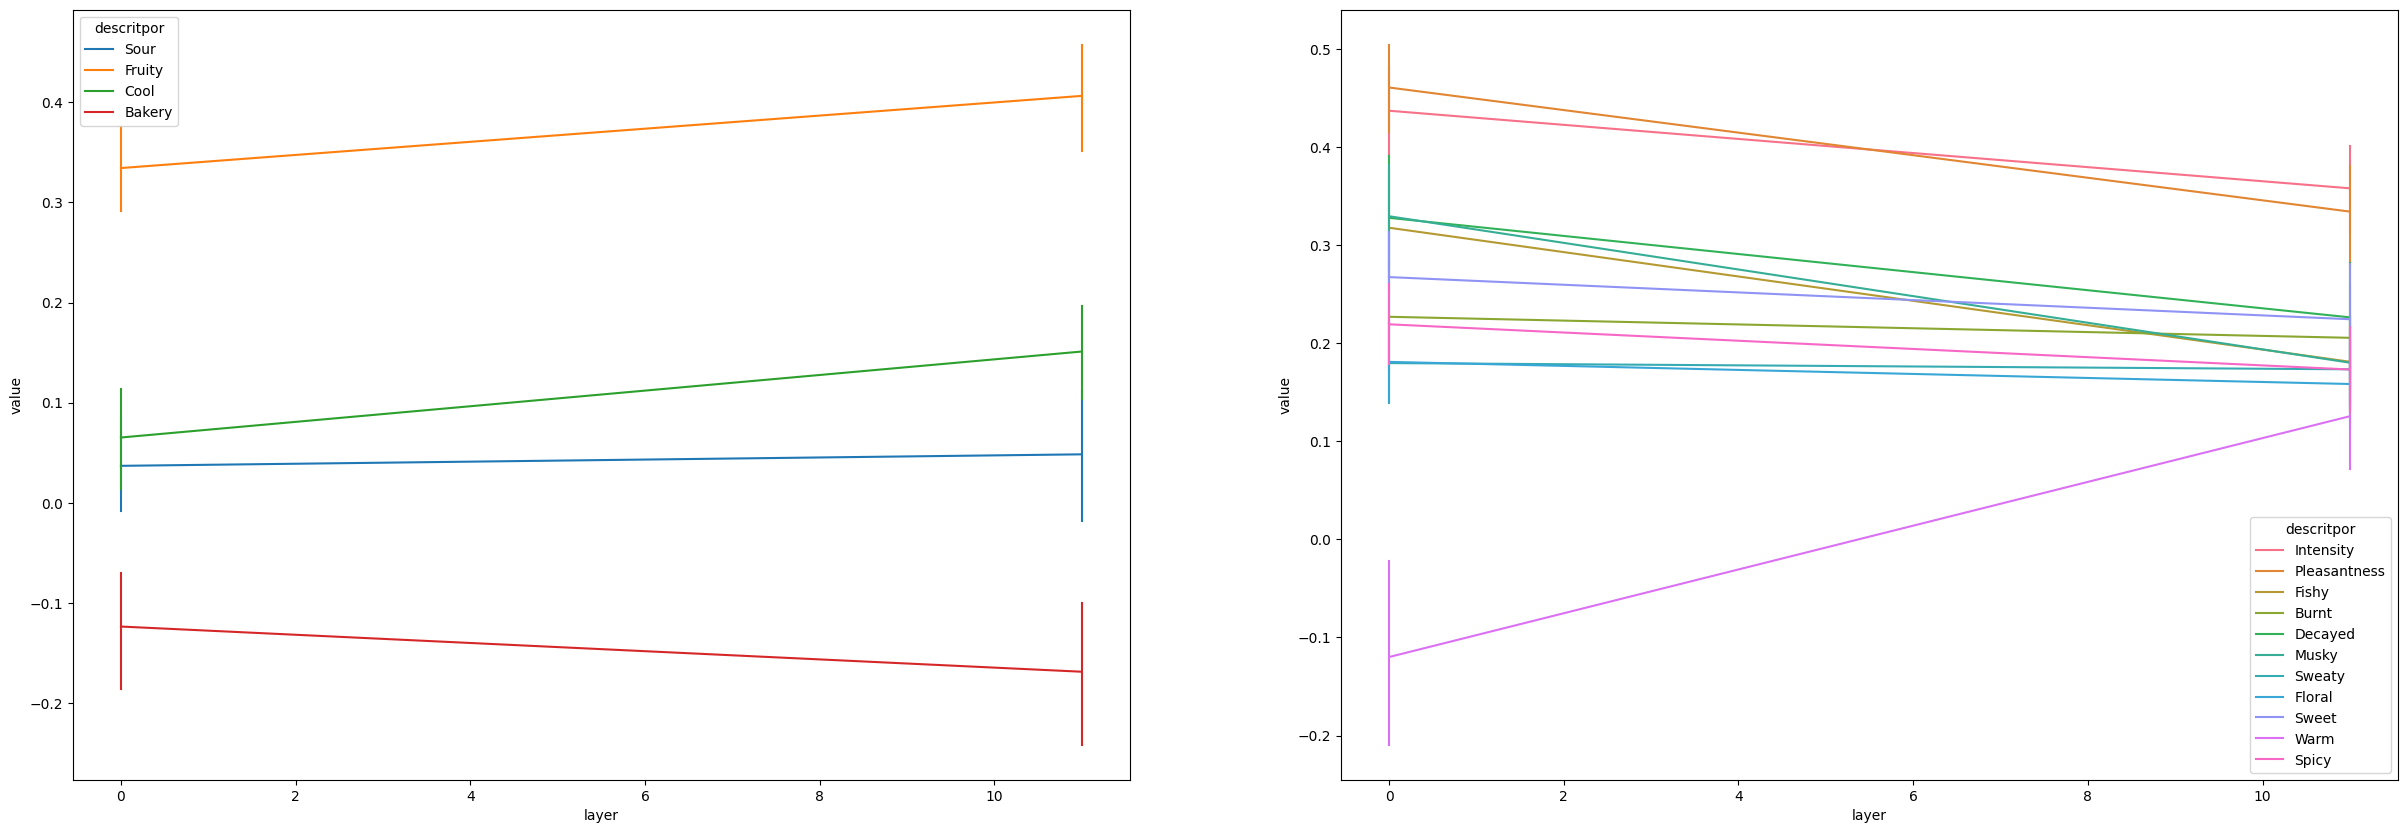

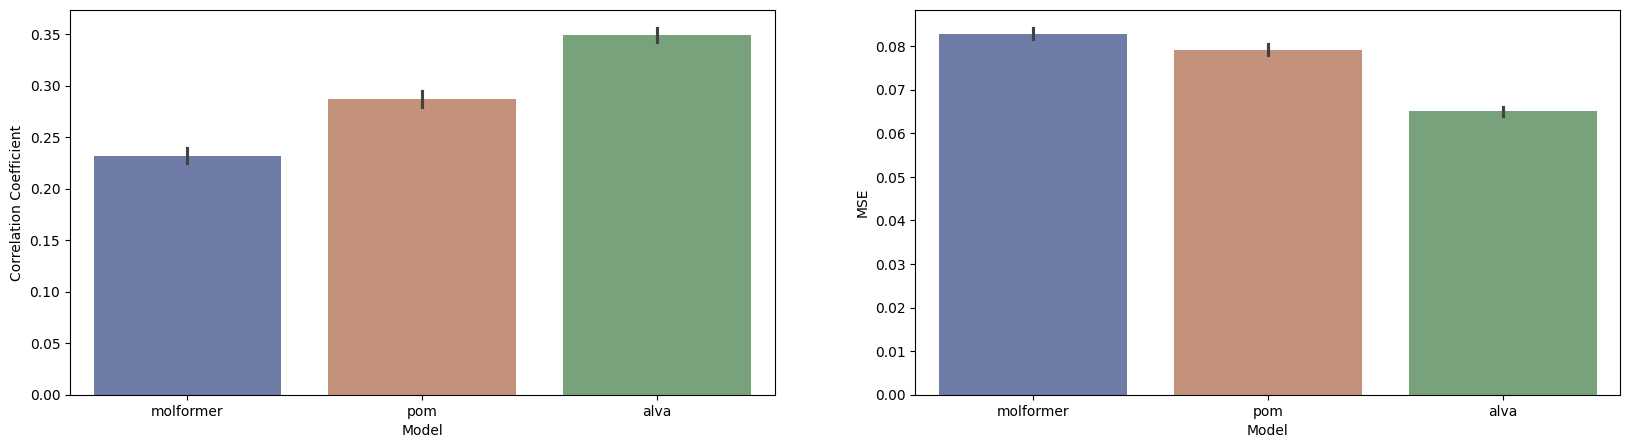

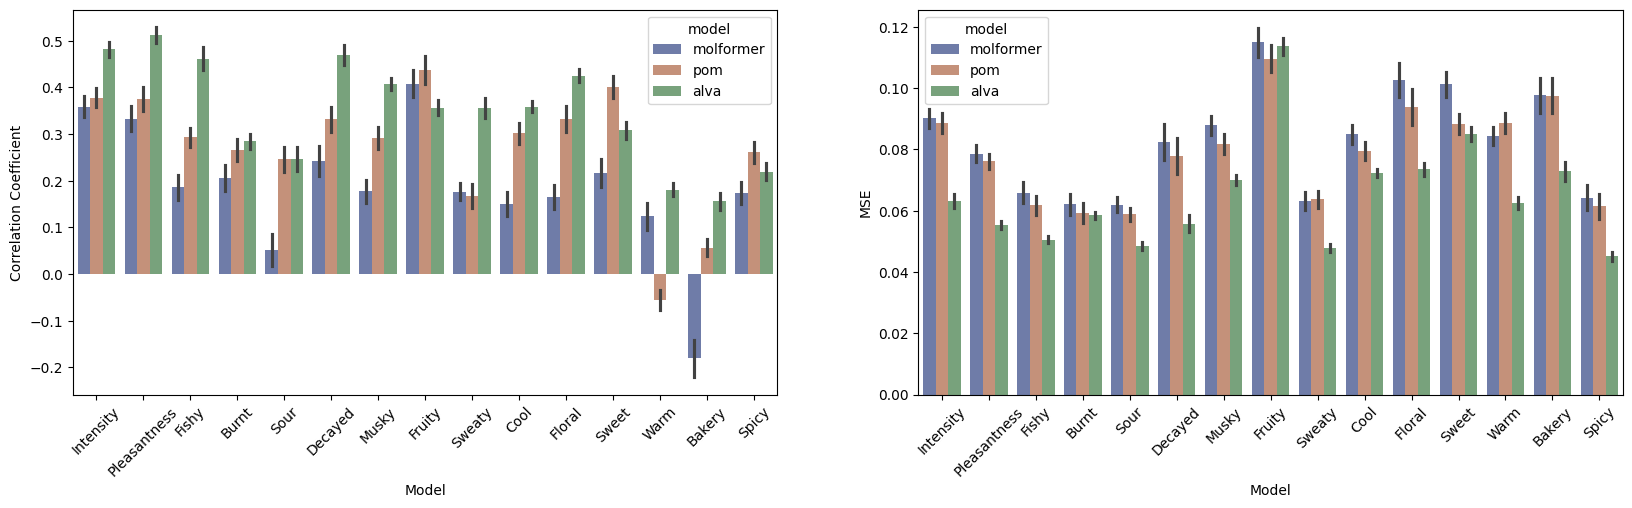

In [45]:
# post_process_dataframe(corrs_molfomer_sagar_true,mses_molformer_sagar_true,df_sagar_cor_pom_true,df_sagar_cor_alva_true,df_sagar_mse_pom_true,df_sagar_mse_alva_true,sagar_tasks)